# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch.nn as nn
import os           
import pandas as pd
import shutil
import random
from torchvision import datasets, transforms
from tqdm import tqdm, trange
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import get_linear_schedule_with_warmup

In [4]:
os.chdir("/content/drive/MyDrive/RecogniVision")

In [5]:
print(os.getcwd())

/content/drive/MyDrive/RecogniVision


In [6]:
initial_path = os.getcwd()
person_folder_base_path =os.path.join(initial_path, os.path.normpath('Dataset/Extracted/'))
data_path = os.path.normpath('Dataset/lfw-deepfunneled/lfw-deepfunneled/')
print(os.path.join(initial_path,data_path))
print(person_folder_base_path)

/content/drive/MyDrive/RecogniVision/Dataset/lfw-deepfunneled/lfw-deepfunneled
/content/drive/MyDrive/RecogniVision/Dataset/Extracted


In [7]:
os.chdir(initial_path)
c1 = []
c2 = []
with open('people.csv') as f:
	for i,line in enumerate(f):
		if i == 0:
			continue
		c1.append(line.split(',')[0])
		t = line.split(',')[1].split('\n')[0]
		if(t == ''):
			t = 0
		else:
			t = int(t)
		c2.append(t)
c1 = np.array(c1)
c2 = np.array(c2)
idx = np.argsort(-c2)
c1 = c1[idx][:10]
c2 = c2[idx][:10]
print(c1)
print(c2)
N_images = 52

['George_W_Bush' 'Colin_Powell' 'Tony_Blair' 'Donald_Rumsfeld'
 'Gerhard_Schroeder' 'Ariel_Sharon' 'Hugo_Chavez' 'Junichiro_Koizumi'
 'Jean_Chretien' 'John_Ashcroft']
[530 236 144 121 109  77  71  60  55  53]


In [8]:
# os.chdir(initial_path+data_path)
# print(os.getcwd())
# print(initial_path)
# os.chdir('../../../')
# print(os.getcwd())

In [9]:
# for indexx in range(0,len(c1)):

#     path = os.path.join(initial_path,data_path)
#     folder = os.path.join(path,c1[indexx])
#     os.chdir(folder)
#     # print(os.getcwd())

#     # plt.imshow(img.imread(img_path))



#     person_image_path = os.path.join(person_folder_base_path,c1[indexx])
#     print(person_image_path)
#     os.makedirs(person_image_path)

#     choices = range(1,c2[indexx])
#     ran_idx_array = random.sample(choices, N_images)

#     for t in range(0,N_images):
#         ran_idx = ran_idx_array[t]
#         img_path = os.path.join(folder,c1[indexx]+"_%04d.jpg" % (ran_idx))
#         # print(img_path)
#         paste_path = os.path.join(person_image_path,c1[indexx]+"_%04d.jpg" % (ran_idx))
#         shutil.copyfile(img_path, paste_path)
#         # print(paste_path)
#         image2 = img.imread(paste_path)
#         # plt.imshow(image2)
#         os.walk('George_W_Bush')

# \<Add Normalization\>

In [10]:
transform = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])
dataset = datasets.ImageFolder(person_folder_base_path, transform = transform)
train_dataset,test_dataset,val_dataset = random_split(dataset, [0.6,0.2,0.2])

mean = 0.0
for images, _ in train_dataset: #image dim: 128*3*64*64
    # batch_samples = images.size(0) # get batch size
    images = images.view(images.size(0), -1) # reshape to 128*3*4096
    mean += images.mean(1) # mean by collapsing dimension 2 then sum over dimension 1
mean = mean / len(train_dataset) # divide by total dataset as we only divided by 4096 and not 128 also

var = 0.0
for images, _ in train_dataset:
    images = images.view(images.size(0), -1)
    var += ((images - mean.unsqueeze(1))**2).mean(1)
std = torch.sqrt(var / (len(train_dataset)))

print(mean)
print(std)

tensor([0.4007, 0.3535, 0.3167])
tensor([0.3038, 0.2752, 0.2655])


In [11]:
train_dataset.dataset.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean,std=std)
            ])
val_dataset.dataset.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean,std=std)
            ])
test_dataset.dataset.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean,std=std)
            ])

In [12]:
mean = 0.0
for images, _ in train_dataset: #image dim: 128*3*64*64
    # batch_samples = images.size(0) # get batch size
    images = images.view(images.size(0), -1) # reshape to 128*3*4096
    mean += images.mean(1) # mean by collapsing dimension 2 then sum over dimension 1
mean = mean / len(train_dataset) # divide by total dataset as we only divided by 4096 and not 128 also

var = 0.0
for images, _ in train_dataset:
    images = images.view(images.size(0), -1)
    var += ((images - mean.unsqueeze(1))**2).mean(1)
std = torch.sqrt(var / (len(train_dataset)))

print(mean)
print(std)

tensor([-5.6357e-08,  3.0528e-07,  3.2592e-07])
tensor([1.0000, 1.0000, 1.0000])


In [13]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# len_tr=len(train_dataset)
# len_va=len(val_dataset)
# len_te=len(test_dataset)
# tot = len_te+len_tr+len_va
# print(len_tr, len_tr/tot)
# print(len_va, len_va/tot)
# print(len_te, len_te/tot)

# images, labels = next(iter(train_loader))
# helper.imshow(images[0], normalize=False)
# plt.imshow(images[9].permute(1,2,0))
# num_occur = np.zeros(10)
# max = 0
# for item in labels:
#     num_occur[item] += 1
#     if item>max:
#         max = int(item)
# print(num_occur)
# print(num_occur.sum())
# print(max)
# print(len(labels))

In [14]:
def train(args, train_dataset, val_dataset, model):
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args["train_batch_size"])
    train_batch_size = args["train_batch_size"]

    t_total = len(train_dataloader) * args["num_train_epochs"]
    optimizer = args["optimizer"](model.parameters(), lr=args["learning_rate"], eps=args["adam_epsilon"])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=t_total // 10, num_training_steps=t_total)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=8, threshold=0.0001)
    lossfn = nn.CrossEntropyLoss()  # defining the loss function
    
    # Training
    print("***** Running training *****")
    print("  Num examples = ", len(train_dataset))
    print("  Num Epochs = ", args["num_train_epochs"])
    print("  Instantaneous batch size per GPU = ", train_batch_size)
    
    batch_iterator = 0 # Holds the batch number
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    
    # Show progress bar
    train_iterator = trange(int(args["num_train_epochs"]), desc="Epoch")
    
    # but will this work for multi-class?
    best_f1_score = 0
    if not os.path.exists(args["output_dir"]):
        os.makedirs(args["output_dir"])
        
    patience = 15
    last_best_epoch = -1
        
    for epoch in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        
        for step, batch in enumerate(epoch_iterator):
            model.train()

            batch = tuple(t.to(args["device"]) for t in batch)  # This brings the input batch of training data onto the same device as the model (i.e. CPU or GPU)
            input_, labels_ = batch
            outputs = model(input_)
            # print(input_.shape)
            # print(labels_.shape)
            # print(outputs.shape)

            loss = lossfn(outputs, labels_) # Here, Cross Entropy Loss
            l2norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + args["lambda"]*l2norm

            loss.backward()
            
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), args["max_grad_norm"])

            tr_loss += loss.item()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            optimizer.zero_grad()
            batch_iterator += 1

        print("Train loss: {}".format(tr_loss/batch_iterator))
        train_losses.append(tr_loss/batch_iterator)
        
        # get train accuracy
        print("Train accuracy stats: ")
        results = evaluate(args, train_dataset, model)
        print("Train accuracy: {}".format(results["acc"]))
        train_acc.append(results["acc"])

        # Recording validation f1 scores
        results = evaluate(args, val_dataset, model)
        print("Validation accuracy: {}".format(results["acc"]))
        print("Validation loss: {}".format(results["eval_loss"]))
        
        # scheduler.step(results["eval_loss"])

        val_losses.append(results["eval_loss"])
        val_acc.append(results["acc"])
        
        if results.get('f1') > best_f1_score and args["save_steps"] > 0:
            best_f1_score = results.get('f1')
            model_to_save = model.module if hasattr(model, "module") else model
            torch.save(model_to_save.state_dict(), args["output_dir"] + "clssnn.pth")
            torch.save(args, os.path.join(args["output_dir"], "training_args.bin"))
            last_best_epoch = epoch
            print("Last best epoch is {}".format(last_best_epoch))
        elif epoch - last_best_epoch > patience:
            print("Early stopped at epoch {}".format(epoch))
            break
    
    return train_losses, train_acc, val_losses, val_acc

In [15]:
def evaluate(args, val_dataset, model):
    
    eval_sampler = SequentialSampler(val_dataset)
    eval_dataloader = DataLoader(val_dataset, sampler=eval_sampler, batch_size=args["eval_batch_size"])
    
    results = {}
    lossfn = nn.CrossEntropyLoss()

    print("  Num examples = ", len(val_dataset))
    print("  Batch size = ", args["eval_batch_size"])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args["device"]) for t in batch)

        with torch.no_grad():
            inputs, labels_ = batch

            outputs = model(inputs)  # forward pass
            logits = outputs

            loss = lossfn(outputs, labels_)
            l2norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + args["lambda"]*l2norm
            eval_loss += loss.mean().item()

        nb_eval_steps += 1

        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels_.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels_.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    result = acc_and_f1(preds, out_label_ids)
    results.update(result)
    results["eval_loss"] = eval_loss

    return results

In [16]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average='weighted')
    precision = precision_score(
        y_true=labels, y_pred=preds, average='weighted')
    recall = recall_score(y_true=labels, y_pred=preds, average='weighted')
    
    return{
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
        "precision": precision,
        "recall": recall
    }

In [17]:
def conv_block(in_channels, out_channels,args,pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=5, padding="same"),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(),
              nn.Dropout(args["dropout"])]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    # layers.append()
    return nn.Sequential(*layers)

class Model(nn.Module):
    def __init__(self, args):
        super(Model, self).__init__()
        self.conv1 = conv_block(3,16,args) # 16 x 256 x 256
        self.conv2 = conv_block(16,32,args,pool=True) # 32 x 128 x 128
        self.res1 = nn.Sequential(conv_block(32,32,args), # 32 x 128 x 128
                                  conv_block(32,32,args)) # 32 x 128 x 128
        
        # self.conv3 = conv_block(32,32,args,pool=True) # 32 x 64 x 64
        # self.conv4 = conv_block(32,32,args,pool=True) # 32 x 32 x 32
        # self.res2 = nn.Sequential(conv_block(32,32,args), # 32 x 32 x 32
        #                           conv_block(32,32,args)) # 32 x 32 x 32
        
        self.classifier = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 16 x 16
                                         nn.Flatten(),
                                         nn.Linear(32*64*64,10))
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        # x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.res2(x) + x
        x = self.classifier(x)
        return x

In [18]:
# args = {"seed": 42}
args = {}
device = torch.device("cuda")
args["device"] = device
print(args["device"])


args["train_batch_size"] = 128
args["eval_batch_size"] = 128
args["num_train_epochs"] = 100
args["optimizer"] = torch.optim.Adam
args["learning_rate"] = 1e-3
args["adam_epsilon"] = 1e-8
args["output_dir"] = "./output/"
args["max_grad_norm"] = 1.0
args["save_steps"] = 1
args["dropout"] = 0.3
args["lambda"] = 0.001

model = Model(args) # ADD ARGUMENT
model.to(args["device"])

cuda


Model(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, 

In [19]:
train_losses, train_acc, val_losses, val_acc = train(args, train_dataset, val_dataset, model)

***** Running training *****
  Num examples =  312
  Num Epochs =  100
  Instantaneous batch size per GPU =  128


Iteration: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Train loss: 5.245251735051473
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.11858974358974358
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:24<00:00, 24.37s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation accuracy: 0.11538461538461539
Validation loss: 2.6960561275482178


Epoch:   1%|          | 1/100 [00:31<52:31, 31.84s/it]

Last best epoch is 0



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 17.70453917980194
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.09615384615384616
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   2%|▏         | 2/100 [00:38<27:22, 16.76s/it]

Validation accuracy: 0.16346153846153846
Validation loss: 4.298934459686279
Last best epoch is 1



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Train loss: 25.269181066089207
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.1891025641025641
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   3%|▎         | 3/100 [00:43<18:49, 11.64s/it]

Validation accuracy: 0.125
Validation loss: 6.030724048614502



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 28.595631857713062
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.11858974358974358
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   4%|▍         | 4/100 [00:49<14:41,  9.18s/it]

Validation accuracy: 0.125
Validation loss: 9.772683143615723



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Train loss: 31.03362930615743
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.20512820512820512
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   5%|▌         | 5/100 [00:55<12:51,  8.12s/it]

Validation accuracy: 0.15384615384615385
Validation loss: 23.527278900146484
Last best epoch is 4



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 34.102565513716804
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.27564102564102566
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   6%|▌         | 6/100 [01:00<11:18,  7.22s/it]

Validation accuracy: 0.2403846153846154
Validation loss: 40.86687469482422
Last best epoch is 5



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 35.29769621576582
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.3076923076923077
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   7%|▋         | 7/100 [01:06<10:34,  6.82s/it]

Validation accuracy: 0.20192307692307693
Validation loss: 45.087989807128906



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Train loss: 33.99704334139824
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.21794871794871795
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   8%|▊         | 8/100 [01:12<09:54,  6.46s/it]

Validation accuracy: 0.1346153846153846
Validation loss: 43.45349884033203



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Train loss: 32.59820024172465
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train accuracy: 0.30448717948717946
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   9%|▉         | 9/100 [01:17<09:18,  6.13s/it]

Validation accuracy: 0.28846153846153844
Validation loss: 41.00980758666992
Last best epoch is 8



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Train loss: 31.115902876853944
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Train accuracy: 0.3333333333333333
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  10%|█         | 10/100 [01:24<09:13,  6.15s/it]

Validation accuracy: 0.15384615384615385
Validation loss: 43.05074691772461



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 29.97076945593863
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train accuracy: 0.358974358974359
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  11%|█         | 11/100 [01:29<08:48,  5.94s/it]

Validation accuracy: 0.2403846153846154
Validation loss: 30.20477867126465



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Train loss: 28.459604733520084
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


Train accuracy: 0.6762820512820513
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  12%|█▏        | 12/100 [01:35<08:40,  5.91s/it]

Validation accuracy: 0.36538461538461536
Validation loss: 18.82647132873535
Last best epoch is 11



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Train loss: 26.853717357684406
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train accuracy: 0.6666666666666666
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  13%|█▎        | 13/100 [01:41<08:32,  5.89s/it]

Validation accuracy: 0.36538461538461536
Validation loss: 20.685718536376953



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 25.461634102321806
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Train accuracy: 0.657051282051282
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  14%|█▍        | 14/100 [01:46<08:14,  5.75s/it]

Validation accuracy: 0.28846153846153844
Validation loss: 20.472156524658203



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Train loss: 24.167877504560682
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train accuracy: 0.8397435897435898
  Num examples =  104
  Batch size =  128



Epoch:  15%|█▌        | 15/100 [01:52<08:24,  5.93s/it]

Validation accuracy: 0.4519230769230769
Validation loss: 10.56035041809082
Last best epoch is 14



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Train loss: 22.747408501182992
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Train accuracy: 0.8525641025641025
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  16%|█▌        | 16/100 [01:59<08:27,  6.04s/it]

Validation accuracy: 0.4326923076923077
Validation loss: 11.610095977783203



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 21.48616574616993
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Train accuracy: 0.8076923076923077
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  17%|█▋        | 17/100 [02:05<08:18,  6.01s/it]

Validation accuracy: 0.4423076923076923
Validation loss: 13.335853576660156
Last best epoch is 16



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Train loss: 20.387931344133836
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train accuracy: 0.9230769230769231
  Num examples =  104
  Batch size =  128



Epoch:  18%|█▊        | 18/100 [02:10<08:08,  5.95s/it]

Validation accuracy: 0.4519230769230769
Validation loss: 13.080559730529785
Last best epoch is 17



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 19.35864977094165
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train accuracy: 0.9487179487179487
  Num examples =  104
  Batch size =  128



Epoch:  19%|█▉        | 19/100 [02:16<07:49,  5.80s/it]

Validation accuracy: 0.47115384615384615
Validation loss: 11.006406784057617



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Train loss: 18.412957519789536
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Train accuracy: 0.8653846153846154
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  20%|██        | 20/100 [02:22<07:57,  5.96s/it]

Validation accuracy: 0.41346153846153844
Validation loss: 16.80060577392578



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Train loss: 17.65783759005486
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train accuracy: 0.9743589743589743
  Num examples =  104
  Batch size =  128



Epoch:  21%|██        | 21/100 [02:28<07:43,  5.87s/it]

Validation accuracy: 0.5192307692307693
Validation loss: 9.93887710571289
Last best epoch is 20



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Train loss: 16.882632086674374
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Train accuracy: 0.9358974358974359
  Num examples =  104
  Batch size =  128



Epoch:  22%|██▏       | 22/100 [02:34<07:36,  5.86s/it]

Validation accuracy: 0.4519230769230769
Validation loss: 12.495606422424316



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Train loss: 16.20407738979312
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Train accuracy: 0.9551282051282052
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  23%|██▎       | 23/100 [02:40<07:31,  5.87s/it]

Validation accuracy: 0.41346153846153844
Validation loss: 12.431966781616211



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 15.569830576578775
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Train accuracy: 0.9487179487179487
  Num examples =  104
  Batch size =  128



Epoch:  24%|██▍       | 24/100 [02:45<07:16,  5.74s/it]

Validation accuracy: 0.5384615384615384
Validation loss: 9.778550148010254
Last best epoch is 23



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Train loss: 14.97072053273519
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train accuracy: 0.9166666666666666
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 25/100 [02:51<07:22,  5.90s/it]

Validation accuracy: 0.40384615384615385
Validation loss: 14.543057441711426



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Train loss: 14.429668364234459
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train accuracy: 0.9198717948717948
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  26%|██▌       | 26/100 [02:57<07:08,  5.79s/it]

Validation accuracy: 0.38461538461538464
Validation loss: 14.065666198730469



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Train loss: 13.919903858576292
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Train accuracy: 0.9326923076923077
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  27%|██▋       | 27/100 [03:03<07:00,  5.77s/it]

Validation accuracy: 0.5096153846153846
Validation loss: 12.822678565979004



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Train loss: 13.476652381320795
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Train accuracy: 0.9647435897435898
  Num examples =  104
  Batch size =  128



Epoch:  28%|██▊       | 28/100 [03:09<06:59,  5.82s/it]

Validation accuracy: 0.4423076923076923
Validation loss: 14.827703475952148



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 13.04726189203646
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train accuracy: 0.9487179487179487
  Num examples =  104
  Batch size =  128



Epoch:  29%|██▉       | 29/100 [03:14<06:45,  5.71s/it]

Validation accuracy: 0.375
Validation loss: 18.078617095947266



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Train loss: 12.648668864369393
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Train accuracy: 0.9326923076923077
  Num examples =  104
  Batch size =  128



Epoch:  30%|███       | 30/100 [03:20<06:48,  5.84s/it]

Validation accuracy: 0.47115384615384615
Validation loss: 13.866853713989258



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Train loss: 12.264582920779464
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train accuracy: 0.9358974358974359
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  31%|███       | 31/100 [03:26<06:40,  5.80s/it]

Validation accuracy: 0.4519230769230769
Validation loss: 15.828254699707031



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 11.905057076054314
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Train accuracy: 0.9583333333333334
  Num examples =  104
  Batch size =  128



Epoch:  32%|███▏      | 32/100 [03:31<06:27,  5.70s/it]

Validation accuracy: 0.4423076923076923
Validation loss: 14.917119979858398



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Train loss: 11.556127232734603
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Train accuracy: 0.9647435897435898
  Num examples =  104
  Batch size =  128



Epoch:  33%|███▎      | 33/100 [03:37<06:30,  5.83s/it]

Validation accuracy: 0.4326923076923077
Validation loss: 17.239389419555664



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 11.226608951009956
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Train accuracy: 0.9935897435897436
  Num examples =  104
  Batch size =  128



Epoch:  34%|███▍      | 34/100 [03:43<06:16,  5.70s/it]

Validation accuracy: 0.5384615384615384
Validation loss: 14.538981437683105



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Train loss: 10.911843348117102
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train accuracy: 1.0
  Num examples =  104
  Batch size =  128



Epoch:  35%|███▌      | 35/100 [03:49<06:18,  5.83s/it]

Validation accuracy: 0.5480769230769231
Validation loss: 13.799626350402832



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Train loss: 10.613719651682509
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train accuracy: 0.9839743589743589
  Num examples =  104
  Batch size =  128



Epoch:  36%|███▌      | 36/100 [03:55<06:09,  5.78s/it]

Validation accuracy: 0.5096153846153846
Validation loss: 15.850205421447754



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 10.341577111466512
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train accuracy: 0.9839743589743589
  Num examples =  104
  Batch size =  128



Epoch:  37%|███▋      | 37/100 [04:00<05:58,  5.69s/it]

Validation accuracy: 0.5384615384615384
Validation loss: 12.729697227478027



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Train loss: 10.082381319581417
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Train accuracy: 0.9935897435897436
  Num examples =  104
  Batch size =  128



Epoch:  38%|███▊      | 38/100 [04:06<06:04,  5.87s/it]

Validation accuracy: 0.5384615384615384
Validation loss: 12.501091957092285
Last best epoch is 37



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 9.832023641619926
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Train accuracy: 0.9551282051282052
  Num examples =  104
  Batch size =  128



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  39%|███▉      | 39/100 [04:12<05:51,  5.76s/it]

Validation accuracy: 0.4807692307692308
Validation loss: 14.821112632751465



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 9.609902784849206
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Train accuracy: 0.9615384615384616
  Num examples =  104
  Batch size =  128



Epoch:  40%|████      | 40/100 [04:18<05:51,  5.86s/it]

Validation accuracy: 0.5
Validation loss: 13.844754219055176



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Train loss: 9.38217824927675
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Train accuracy: 0.9711538461538461
  Num examples =  104
  Batch size =  128



Epoch:  41%|████      | 41/100 [04:24<05:43,  5.83s/it]

Validation accuracy: 0.5576923076923077
Validation loss: 12.207541465759277
Last best epoch is 40



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 9.17156800131003
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train accuracy: 0.9807692307692307
  Num examples =  104
  Batch size =  128



Epoch:  42%|████▏     | 42/100 [04:29<05:33,  5.75s/it]

Validation accuracy: 0.5480769230769231
Validation loss: 10.823975563049316



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Train loss: 8.967025725878486
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Train accuracy: 1.0
  Num examples =  104
  Batch size =  128



Epoch:  43%|████▎     | 43/100 [04:36<05:36,  5.90s/it]

Validation accuracy: 0.5961538461538461
Validation loss: 9.515318870544434
Last best epoch is 42



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 8.768359153446825
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Train accuracy: 1.0
  Num examples =  104
  Batch size =  128



Epoch:  44%|████▍     | 44/100 [04:41<05:24,  5.79s/it]

Validation accuracy: 0.6153846153846154
Validation loss: 10.333292007446289
Last best epoch is 43



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 8.577616111216722
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Train accuracy: 0.9967948717948718
  Num examples =  104
  Batch size =  128



Epoch:  45%|████▌     | 45/100 [04:47<05:22,  5.86s/it]

Validation accuracy: 0.5480769230769231
Validation loss: 13.5349760055542



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Train loss: 8.395636135037394
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train accuracy: 0.9967948717948718
  Num examples =  104
  Batch size =  128



Epoch:  46%|████▌     | 46/100 [04:53<05:16,  5.86s/it]

Validation accuracy: 0.5192307692307693
Validation loss: 13.832256317138672



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 8.222935782785111
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train accuracy: 0.9871794871794872
  Num examples =  104
  Batch size =  128



Epoch:  47%|████▋     | 47/100 [04:59<05:05,  5.77s/it]

Validation accuracy: 0.47115384615384615
Validation loss: 15.065139770507812



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Train loss: 8.056930918660429
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Train accuracy: 0.9967948717948718
  Num examples =  104
  Batch size =  128



Epoch:  48%|████▊     | 48/100 [05:05<05:06,  5.90s/it]

Validation accuracy: 0.4807692307692308
Validation loss: 14.266847610473633



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Train loss: 7.898275538062562
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train accuracy: 1.0
  Num examples =  104
  Batch size =  128



Epoch:  49%|████▉     | 49/100 [05:10<04:54,  5.78s/it]

Validation accuracy: 0.5
Validation loss: 14.233469009399414



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Train loss: 7.743865842223167
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Train accuracy: 0.9967948717948718
  Num examples =  104
  Batch size =  128



Epoch:  50%|█████     | 50/100 [05:16<04:50,  5.81s/it]

Validation accuracy: 0.5096153846153846
Validation loss: 14.545306205749512



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Train loss: 7.602734252810478
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Train accuracy: 0.9903846153846154
  Num examples =  104
  Batch size =  128



Epoch:  51%|█████     | 51/100 [05:22<04:44,  5.80s/it]

Validation accuracy: 0.5576923076923077
Validation loss: 14.256704330444336



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 7.461047926392311
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train accuracy: 1.0
  Num examples =  104
  Batch size =  128



Epoch:  52%|█████▏    | 52/100 [05:27<04:34,  5.72s/it]

Validation accuracy: 0.5192307692307693
Validation loss: 11.593570709228516



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Train loss: 7.323572196394393
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Train accuracy: 0.9903846153846154
  Num examples =  104
  Batch size =  128



Epoch:  53%|█████▎    | 53/100 [05:34<04:36,  5.89s/it]

Validation accuracy: 0.5
Validation loss: 13.640445709228516



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Train loss: 7.193263839608357
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train accuracy: 0.9935897435897436
  Num examples =  104
  Batch size =  128



Epoch:  54%|█████▍    | 54/100 [05:39<04:25,  5.76s/it]

Validation accuracy: 0.5192307692307693
Validation loss: 15.420080184936523



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Train loss: 7.06648704030297
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Train accuracy: 0.9871794871794872
  Num examples =  104
  Batch size =  128



Epoch:  55%|█████▌    | 55/100 [05:45<04:19,  5.77s/it]

Validation accuracy: 0.47115384615384615
Validation loss: 17.41117286682129



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Train loss: 6.943433296024089
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Train accuracy: 0.9935897435897436
  Num examples =  104
  Batch size =  128



Epoch:  56%|█████▌    | 56/100 [05:51<04:15,  5.81s/it]

Validation accuracy: 0.49038461538461536
Validation loss: 17.053958892822266



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Train loss: 6.824636015627119
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Train accuracy: 0.9903846153846154
  Num examples =  104
  Batch size =  128



Epoch:  57%|█████▋    | 57/100 [05:56<04:05,  5.72s/it]

Validation accuracy: 0.49038461538461536
Validation loss: 15.84928035736084



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Train loss: 6.7100492325322385
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Train accuracy: 1.0
  Num examples =  104
  Batch size =  128



Epoch:  58%|█████▊    | 58/100 [06:03<04:08,  5.91s/it]

Validation accuracy: 0.5192307692307693
Validation loss: 13.98421859741211



Iteration: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Train loss: 6.599206582890392
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train accuracy: 0.9935897435897436
  Num examples =  104
  Batch size =  128



Epoch:  59%|█████▉    | 59/100 [06:08<03:57,  5.80s/it]

Validation accuracy: 0.5192307692307693
Validation loss: 13.089405059814453



Iteration: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Train loss: 6.492191346403625
Train accuracy stats: 
  Num examples =  312
  Batch size =  128



Evaluating: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Train accuracy: 1.0
  Num examples =  104
  Batch size =  128



Epoch:  59%|█████▉    | 59/100 [06:15<04:20,  6.36s/it]

Validation accuracy: 0.5480769230769231
Validation loss: 12.485054016113281
Early stopped at epoch 59


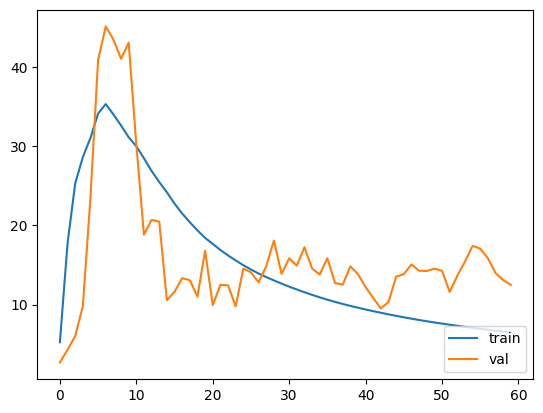

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["train", "val"], loc ="lower right")
plt.show()

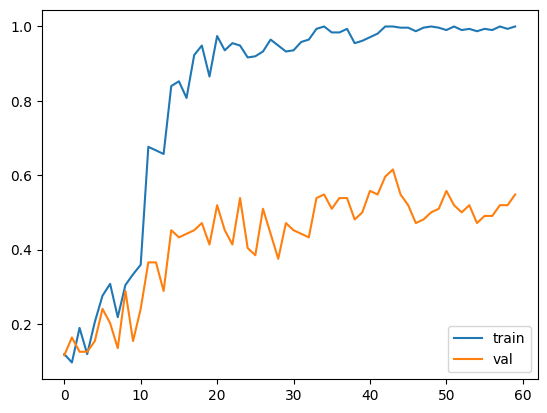

In [21]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["train", "val"], loc ="lower right")
plt.show()

In [22]:
testing = evaluate(args, test_dataset, model)

print('\n\nTesting Accuracy = ',testing["acc"])

  Num examples =  104
  Batch size =  128


Evaluating: 100%|██████████| 1/1 [00:24<00:00, 24.09s/it]



Testing Accuracy =  0.6153846153846154
